# Predicting heart disease

- UCI heart disease data set
- use only 14 features -> 3 age, 4 sex, 9 cp, 10 trestbps, 12 chol, 16 fbs, 19 restecg,
  32 thalach, 38 exang, 40 oldpeak, 41 slope, 44 ca, 51 thal, 58 num
- 14. column -> 58 num
Goals:
- import data
- clean and process
- FFN to predict heart disease -> binarize (zero and nonzero)

# Imports

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

from sklearn.model_selection import train_test_split

# Data processing

In [2]:
header = ["age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", "thalach", "exang", "oldpeak", "slope", "ca", "thal", "num"]
data_pd = pd.read_csv("../sample_data/processed.cleveland.data", header=None)
data_pd.columns = header
data_pd["cancer"] = (data_pd["num"] > 0).astype(int)
data_pd = data_pd.dropna()
data_pd

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num,cancer
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2,1
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
297,57.0,0.0,4.0,140.0,241.0,0.0,0.0,123.0,1.0,0.2,2.0,0.0,7.0,1,1
298,45.0,1.0,1.0,110.0,264.0,0.0,0.0,132.0,0.0,1.2,2.0,0.0,7.0,1,1
299,68.0,1.0,4.0,144.0,193.0,1.0,0.0,141.0,0.0,3.4,2.0,2.0,7.0,2,1
300,57.0,1.0,4.0,130.0,131.0,0.0,0.0,115.0,1.0,1.2,2.0,1.0,7.0,3,1


In [3]:
data_pd.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num,cancer
count,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000
mean,54.542088,0.676768,3.158249,131.693603,247.350168,0.144781,0.996633,149.599327,0.326599,1.055556,1.602694,0.676768,4.730640,0.946128,0.461279
std,9.049736,0.468500,0.964859,17.762806,51.997583,0.352474,0.994914,22.941562,0.469761,1.166123,0.618187,0.938965,1.938629,1.234551,0.499340
min,29.000000,0.000000,1.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,1.000000,0.000000,3.000000,0.000000,0.000000
25%,48.000000,0.000000,3.000000,120.000000,211.000000,0.000000,0.000000,133.000000,0.000000,0.000000,1.000000,0.000000,3.000000,0.000000,0.000000
50%,56.000000,1.000000,3.000000,130.000000,243.000000,0.000000,1.000000,153.000000,0.000000,0.800000,2.000000,0.000000,3.000000,0.000000,0.000000
75%,61.000000,1.000000,4.000000,140.000000,276.000000,0.000000,2.000000,166.000000,1.000000,1.600000,2.000000,1.000000,7.000000,2.000000,1.000000
max,77.000000,1.000000,4.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,3.000000,3.000000,7.000000,4.000000,1.000000


array([[<AxesSubplot:title={'center':'num'}>,
        <AxesSubplot:title={'center':'cancer'}>]], dtype=object)

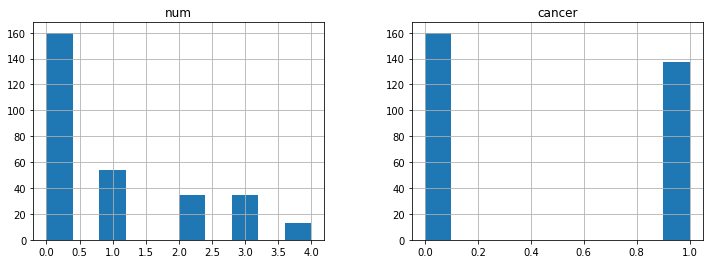

In [4]:
data_pd.hist(["num", "cancer"], figsize=(12, 4))

In [5]:
data_cols = header.copy()
data_cols.remove("num")
z_score_cols = data_cols.copy()
z_score_cols.remove("sex")
z_score_cols.remove("fbs")
z_score_cols.remove("exang")
data_norm = data_pd.copy()
data_norm[z_score_cols] = data_norm[z_score_cols].apply(stats.zscore)
data_norm

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num,cancer
0,0.936181,1.0,-2.240629,0.750380,-0.276443,1.0,1.010199,0.017494,0.0,1.068965,2.264145,-0.721976,0.655877,0,0
1,1.378929,1.0,0.873880,1.596266,0.744555,0.0,1.010199,-1.816334,1.0,0.381773,0.643781,2.478425,-0.894220,2,1
2,1.378929,1.0,0.873880,-0.659431,-0.353500,0.0,1.010199,-0.899420,1.0,1.326662,0.643781,1.411625,1.172577,1,1
3,-1.941680,1.0,-0.164289,-0.095506,0.051047,0.0,-1.003419,1.633010,0.0,2.099753,2.264145,-0.721976,-0.894220,0,0
4,-1.498933,0.0,-1.202459,-0.095506,-0.835103,0.0,1.010199,0.978071,0.0,0.295874,-0.976583,-0.721976,-0.894220,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
297,0.272059,0.0,0.873880,0.468418,-0.122330,0.0,-1.003419,-1.161395,1.0,-0.734914,0.643781,-0.721976,1.172577,1,1
298,-1.056185,1.0,-2.240629,-1.223355,0.320744,0.0,-1.003419,-0.768432,0.0,0.124076,0.643781,-0.721976,1.172577,1,1
299,1.489615,1.0,0.873880,0.693988,-1.047008,1.0,-1.003419,-0.375469,0.0,2.013854,0.643781,1.411625,1.172577,2,1
300,0.272059,1.0,0.873880,-0.095506,-2.241384,0.0,-1.003419,-1.510696,1.0,0.124076,0.643781,0.344824,1.172577,3,1


In [6]:
data_norm.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num,cancer
count,2.970000e+02,297.000000,2.970000e+02,2.970000e+02,2.970000e+02,297.000000,2.970000e+02,2.970000e+02,297.000000,297.000000,2.970000e+02,2.970000e+02,2.970000e+02,297.000000,297.000000
mean,-1.226105e-16,0.676768,-4.037175e-17,4.904420e-16,-1.958777e-16,0.144781,4.784800e-17,4.784800e-16,0.326599,0.000000,-1.136390e-16,-7.775299e-17,-1.196200e-16,0.946128,0.461279
std,1.001688e+00,0.468500,1.001688e+00,1.001688e+00,1.001688e+00,0.352474,1.001688e+00,1.001688e+00,0.469761,1.001688,1.001688e+00,1.001688e+00,1.001688e+00,1.234551,0.499340
min,-2.827176e+00,0.000000,-2.240629e+00,-2.125634e+00,-2.337704e+00,0.000000,-1.003419e+00,-3.431849e+00,0.000000,-0.906712,-9.765832e-01,-7.219761e-01,-8.942201e-01,0.000000,0.000000
25%,-7.241238e-01,0.000000,-1.642895e-01,-6.594306e-01,-7.002541e-01,0.000000,-1.003419e+00,-7.247694e-01,0.000000,-0.906712,-9.765832e-01,-7.219761e-01,-8.942201e-01,0.000000,0.000000
50%,1.613719e-01,1.000000,-1.642895e-01,-9.550637e-02,-8.380217e-02,0.000000,3.389928e-03,1.484822e-01,0.000000,-0.219520,6.437811e-01,-7.219761e-01,-8.942201e-01,0.000000,0.000000
75%,7.148067e-01,1.000000,8.738802e-01,4.684179e-01,5.519138e-01,0.000000,1.010199e+00,7.160957e-01,1.000000,0.467672,6.437811e-01,3.448244e-01,1.172577e+00,2.000000,1.000000
max,2.485798e+00,1.000000,8.738802e-01,3.851964e+00,6.099981e+00,1.000000,1.010199e+00,2.287949e+00,1.000000,4.419026,2.264145e+00,2.478425e+00,1.172577e+00,4.000000,1.000000


In [7]:
data = data_pd[data_cols].values
labels = data_pd["cancer"].values.reshape((data_pd.shape[0], 1))
data.shape, labels.shape

((297, 13), (297, 1))

In [8]:
dataT = torch.tensor(data).float()
labelsT = torch.tensor(labels).float()

data_train, data_test, labels_train, labels_test = train_test_split(dataT, labelsT, test_size=0.1)

dataset_train = TensorDataset(data_train, labels_train)
dataset_test = TensorDataset(data_test, labels_test)

batchsize  = 8
train_loader = DataLoader(dataset_train, batch_size=batchsize, shuffle=True, drop_last=True)
test_loader = DataLoader(dataset_test, batch_size=dataset_test.tensors[0].shape[0])

# Model setup

In [9]:
class CancerModel(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.input = nn.Linear(13, 32)
        self.hidden1 = nn.Linear(32, 32)
        self.output = nn.Linear(32, 1)

    def forward(self, x):
        x = F.relu(self.input(x))
        x = F.relu(self.hidden1(x))
        return self.output(x)


def get_model():
    model = CancerModel()
    loss_function = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    return model, loss_function, optimizer

# Training

In [10]:
def train_model(epochs, train_loader, test_loader):
    losses = []
    train_acc = []
    test_acc = []

    model, loss_function, optimizer = get_model()

    for _ in range(epochs):
        model.train()
        batch_losses = []
        batch_acc = []
        for X, y in train_loader:
            y_pred = model(X)
            loss = loss_function(y_pred, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            batch_acc.append(100*torch.mean(((torch.sigmoid(y_pred)>.5).float() == y).float()).item())
            batch_losses.append(loss.item())

        train_acc.append(np.mean(batch_acc))        
        losses.append(np.mean(batch_losses))        
        
        model.eval()
        X, y = next(iter(test_loader))
        with torch.no_grad():
            y_pred = model(X)
        test_acc.append(100*torch.mean(((torch.sigmoid(y_pred)>.5) == y).float()).item())

    return model, losses, train_acc, test_acc

### Test training

In [11]:
epochs = 100
model, losses, train_acc, test_acc = train_model(epochs, train_loader, test_loader)

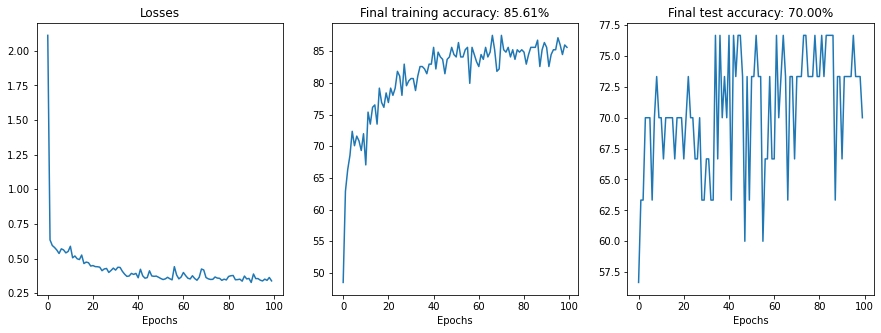

In [12]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
ax1.plot(losses)
ax1.set_xlabel("Epochs")
ax1.set_title("Losses")
ax2.plot(train_acc)
ax2.set_title(f"Final training accuracy: {train_acc[-1]:.2f}%")
ax2.set_xlabel("Epochs")
ax3.plot(test_acc)
ax3.set_title(f"Final test accuracy: {test_acc[-1]:.2f}%")
ax3.set_xlabel("Epochs")
plt.show()

In [13]:
X, y = next(iter(test_loader))
y_pred = model(X)

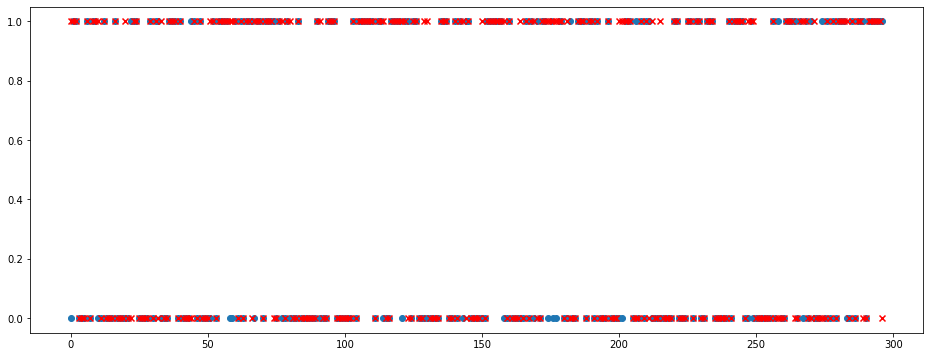

In [14]:
y_pred = model(dataT).detach().numpy() > 0
fig, ax = plt.subplots(1, 1, figsize=(16, 6))
ax.scatter(np.arange(len(labels)), labels)
ax.scatter(np.arange(len(y_pred)), y_pred, c="r", marker="x")